# Playing with graphs

* Used data from crunch base on unicorn companies (>1e9 valuation). 
* Looking to see if company-company graph is small world. Company-company graph has companies as the nodes and investors as edges.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.sparse.csgraph import johnson
import jgraph
from igraph import *
from time import time
from joblib import Parallel, delayed
from joblib import load, dump
from tqdm import tqdm
from scipy.sparse import csr_matrix

In [2]:
# Load startups dataset

Startups = pd.read_csv('unicorns.tsv', sep='\t')
print("Number of companies unicorns: %d" %len(pd.unique(Startups.Company)))

Number of companies unicorns: 163


In [3]:
Startups.head()

,Company,Valuation ($B),Date Joined,Country,Industry,Select Investors -- this data from https://www.cbinsights.com/research-unicorn-companies
0,23andMe,$1.03,7/3/2015,USA,Healthcare,"Google Ventures, New Enterprise Associates, MP..."
1,AUTO1 Group,$1.2,8/3/2015,Germany,eCommerce/Marketplace,"Digital Sky Technologies, Piton Capital, DN Ca..."
2,AVAST Software,$1,2/5/2014,Czech Republic,Cybersecurity,"Summit Partners, CVC Capital Partners"
3,Actifio,$1.1,3/24/2014,USA,Big Data,"Greylock Partners, North Bridge Venture Partne..."
4,Adyen,$2.3,12/16/2014,Netherlands,Fintech,"Felicis Ventures, Index Ventures, Temasek Hold..."


In [5]:
#Load investors dataset 

Investors = pd.read_csv('investors_in_unicorns.tsv', sep='\t')
print("Number of investors: %d" %len(pd.unique(Investors.Investor)))

Number of investors: 791


In [6]:
Investors.head()

,Company,Investor,category_list,raised_amount_usd,Valuation ($B),funded_at,Country,Industry,Select Investors
0,23andMe,Anne Wojcicki,Biotechnology|Search,57949900.0,$1.03,7/3/2015,USA,Healthcare,"Google Ventures, New Enterprise Associates, MP..."
1,23andMe,Casdin Capital,Biotechnology|Search,115000000.0,$1.03,7/3/2015,USA,Healthcare,"Google Ventures, New Enterprise Associates, MP..."
2,23andMe,Eric Lederman,Biotechnology|Search,100000.0,$1.03,7/3/2015,USA,Healthcare,"Google Ventures, New Enterprise Associates, MP..."
3,23andMe,Fidelity Management & Research,Biotechnology|Search,115000000.0,$1.03,7/3/2015,USA,Healthcare,"Google Ventures, New Enterprise Associates, MP..."
4,23andMe,Genentech,Biotechnology|Search,9000000.0,$1.03,7/3/2015,USA,Healthcare,"Google Ventures, New Enterprise Associates, MP..."


In [149]:
# Are all companies in unicorn dataset in investor dataset

set(Startups.Company).issuperset(Investors.Company)

True

In [150]:
set(Investors.Company).issuperset(Startups.Company)
print("Not all companies in the Investors dataset")

Not all companies in the Investors dataset


In [151]:
unicorn_cc = pd.merge( left=Investors[["Investor","Company"]], 
                      right=Investors[["Investor","Company"]], how="inner",
                      left_on="Investor", 
                      right_on="Investor").drop_duplicates()

unicorn_cc = unicorn_cc[unicorn_cc['Company_x'] != unicorn_cc['Company_y'] ]

unicorn_cc.head(10)

,Investor,Company_x,Company_y
7,Google,23andMe,Magic Leap
11,Google,Magic Leap,23andMe
16,Google Ventures,23andMe,Carbon3D
17,Google Ventures,23andMe,Cloudera
18,Google Ventures,23andMe,DocuSign
20,Google Ventures,23andMe,Gusto
21,Google Ventures,23andMe,Jet
23,Google Ventures,23andMe,Kabam
24,Google Ventures,23andMe,Nextdoor
25,Google Ventures,23andMe,Slack


In [152]:
def fixup(s):
   return s.replace('-','_').replace('(','_').replace(')','_').replace('&','_').replace('/','_').replace('.','_').replace('!','_')


In [153]:
# Create unique dictionary of companies and investors to draw edges

G=nx.Graph()
unicorn_list = []
for x in Investors[['Company', 'Investor']].values:
    company = x[0].replace(' ','_')
    investor = x[1].replace(' ','_')
    unicorn_list.append([company, investor])

for company in unicorn_list:
    G.add_node(company[0])

investor_dict = {}    
for company, investor in unicorn_list:
    if investor in investor_dict.keys():
        if company not in investor_dict[investor]:
            investor_dict[investor].append(company)
    else:
        investor_dict[investor] = [company]

for investor in investor_dict.keys():
    company_edge_start = investor_dict[investor][0]
    if(len(investor_dict[investor]) > 1):
        for company in investor_dict[investor]:
            G.add_edge(company_edge_start, company)
            company_edge_start = company

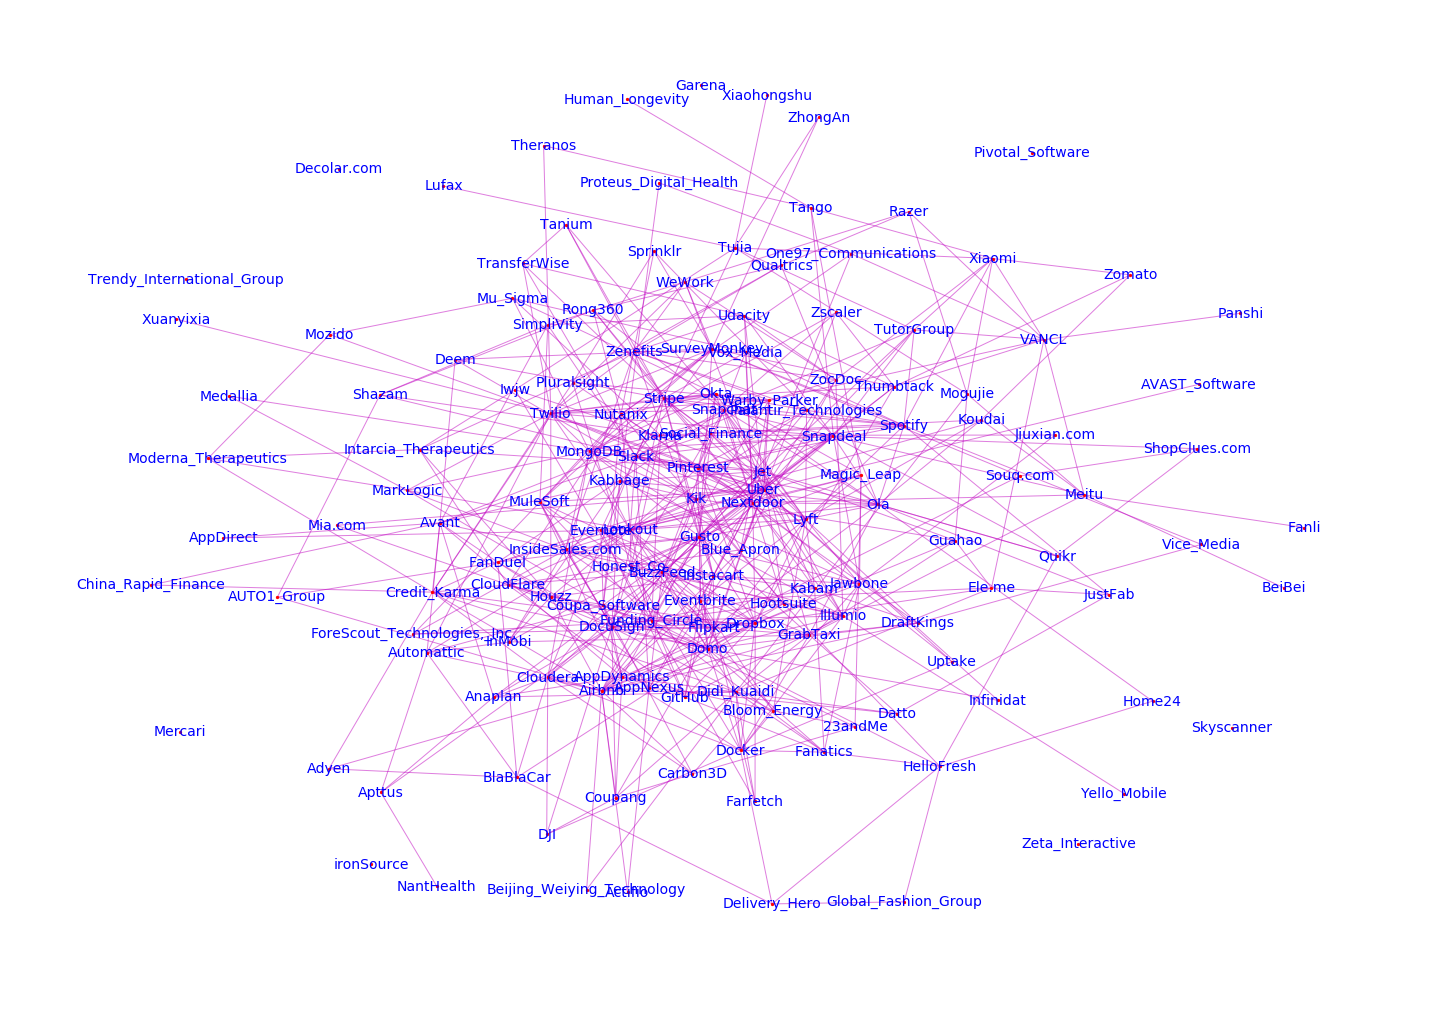

In [154]:
plt.figure(figsize=(25,18))

pos = nx.fruchterman_reingold_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=5)

nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for (u,v,d) in G.edges(data=True)], width=1, edge_color="m", alpha=0.5)

nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif', font_color="b", alpha=0.4)

plt.axis('off')

plt.show()

Excludes investors if they only invested in one company.

In [155]:
print("Number of nodes: %d" % G.number_of_nodes())
print("Number of edges: %d" % G.number_of_edges())

Number of nodes: 147
Number of edges: 668


## Determining number of connected components

In graph theory, a connected component (or just component) of an undirected graph is a subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the supergraph.

In [156]:
print("Number of connected components in the graph: %d" %nx.number_connected_components(G))

Number of connected components in the graph: 9


## Determining the diameter of the largest component (greatest distance between 2 companies).

* The eccentricity of a node v is the maximum distance from v to all other nodes in G.
* The diameter is the maximum eccentricity.

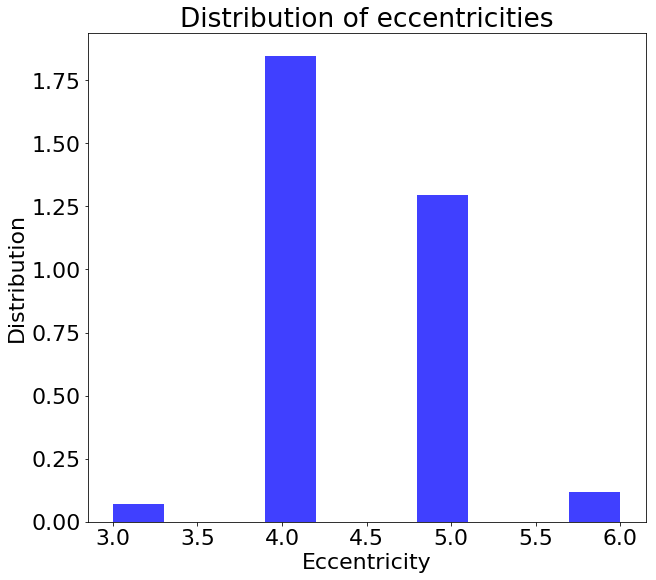

In [165]:
#Remove isolated nodes
G_clean = G
for node in nx.isolates(G_clean):
    G_clean.remove_node(node)

#Get Eccentricities
eccentricities = nx.eccentricity(G_clean)

plt.figure(figsize=(10,9))
plt.hist(list(eccentricities.values()), 10, normed=1, facecolor='blue', alpha=0.75)
plt.title("Distribution of eccentricities")
plt.ylabel("Distribution")
plt.xlabel("Eccentricity")
plt.show()

In [166]:
print("The diameter of the graph is %d." % nx.diameter(G_clean))

The diameter of the graph is 6.


### Company-investor graph of unicorns

* Want to see relationshiip between company-company graph diamater to company-investor graph diameter. Back of the envelop calculation puts this relationship at ~1:2, but confirming with this work. This is needed for the much larger dataset of all Crunchbase companies.

In [167]:
#Computer diameter of company-investor graph for unicorns


Gci_unicorns = Graph(directed = False)

for x in Investors[['Company', 'Investor']].values:
    startup  = fixup(str(x[0]))
    investor = fixup(str(x[1]))
    Gci_unicorns.add_vertices(startup)
    Gci_unicorns.add_vertices(investor)
    Gci_unicorns.add_edge( startup, investor )
    
print("Number of nodes in the company-investor graph: %d" % Gci_unicorns.vcount())
print("Number of edges in the company-investor graph: %d" % Gci_unicorns.ecount())
print("Diameter of company-investor graph for unicorns: %d" % Gci_unicorns.diameter())


Number of nodes in the company-investor graph: 4742
Number of edges in the company-investor graph: 2371
Diameter of company-investor graph for unicorns: 10


Confirmed that ratio of diamters in the company-company graph to company-investor graph is approximately 1:2. 

## Compute the clustering coefficient C_delta (= (3 times the number of triangles) / (the number of paths of length 2)), and use it to determine whether the network is a small-world network.

* The triangles function computes the number of triangles that include a node as one vertex.
* Small-world networks tend to contain cliques, and near-cliques, meaning sub-networks which have connections between almost any two nodes within them. This follows from the defining property of a high clustering coefficient. Secondly, most pairs of nodes will be connected by at least one short path. This follows from the defining property that the mean-shortest path length be small. Several other properties are often associated with small-world networks. Typically there is an over-abundance of hubs – nodes in the network with a high number of connections (known as high degree nodes). These hubs serve as the common connections mediating the short path lengths between other edges. By analogy, the small-world network of airline flights has a small mean-path length (i.e. between any two cities you are likely to have to take three or fewer flights) because many flights are routed through hub cities.

In [172]:
# Extract number of triables per node
triangles = nx.triangles(G)


# Find path's of length 2 from each node
def findPaths(G,u,n):
    if n==0:
        return [[u]]
    paths = []
    for neighbor in G.neighbors(u):
        for path in findPaths(G,neighbor,n-1):
            if u not in path:
                paths.append([u]+path)
    return paths


findPaths(G,'Evernote',2)[:4]

[['Evernote', 'Nextdoor', 'Stripe'],
 ['Evernote', 'Nextdoor', 'Udacity'],
 ['Evernote', 'Nextdoor', 'Ola'],
 ['Evernote', 'Nextdoor', 'Meitu']]

In [173]:
# Compute clustering coefficient
path2_len = []
for node in G.nodes():
    path2_len.append( len(findPaths(G,node,2)) ) 

C_observed = 3 * sum(triangles.values()) / sum(path2_len)
L_observed = nx.average_shortest_path_length(G)

print("The mean clustering coeffcient is %f." % nx.average_clustering(G))
print("The clustering coefficient is %f." % C_observed)    
print("The mean shortest path length is %f." % L_observed)

The mean clustering coeffcient is 0.184359.
The clustering coefficient is 0.270076.
The mean shortest path length is 2.692107.


In [174]:
#Compute 'small-world-ness' according to Humphries and Gurney 2008

C = []
L = []


for i in range(10): 
    
    G_random = nx.gnm_random_graph(n = len(G.nodes()), m = G.number_of_edges())
    clustering_coef_rand = {}
    triangles = nx.triangles(G_random)
    
    path2_len = []
    for node in G_random.nodes():
        path2_len.append(len(findPaths(G_random, node, 2)))        
    C.append(3 * sum(triangles.values()) / sum(path2_len))
    L.append(nx.average_shortest_path_length(G_random))
    
(C_observed / np.mean(C)) / (L_observed / np.mean(L))   

2.3138995835002745

According to Humphries and Gurney, this graph would be considered small world because the small-world-ness metric is above one. 